In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import matplotlib.patches as patches
import resting_state_summaries as rss

In [2]:
def is_in_interval(number, interval_start, interval_end, include_start=True, include_end=True):
    if include_start and include_end:
        return interval_start <= number <= interval_end
    elif include_start:
        return interval_start <= number < interval_end
    elif include_end:
        return interval_start < number <= interval_end
    else:
        return interval_start < number < interval_end

In [3]:
with open('Final_model/K6_D10_500subjs_compact_model.pkl', 'rb') as f:
    [model, q, elbos, q_z] = pickle.load(f)
num_roi = model.N
num_subject = len(np.unique(model.tags))
pid = np.unique(model.tags)
K = model.K

/home/xzhou126/miniconda3/envs/slds/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
with open('summary_data/q_x.pkl', 'rb') as f:
    q_x = pickle.load(f)
with open('data/tags_rsfMRI_HCP_held_out', 'rb') as f:
    tags = pickle.load(f)
tags_fitted = list(np.concatenate([np.repeat(pid[l], 4) for l in range(len(pid))]))
with open('summary_data/state_order.pkl','rb') as f:
   state_order = pickle.load(f)

In [5]:
with open('summary_data/transition_courses_importance.pkl','rb') as f:
    transition_courses = pickle.load(f)
# collect significant transitions
transitions_of_interest = []
K = 6
for k1 in range(K):
    for k2 in range(K):
        if len(transition_courses[k1][k2])>0:
            transitions_of_interest.append([k1, k2])
transitions_of_interest = np.array(transitions_of_interest)
num_transitions = transitions_of_interest.shape[0]

In [6]:
z_subject = dict()
for s in range(num_subject):
    z_subject[s] = [q_z[i] for i in range(len(q_z)) if tags[i] == pid[s]]
z_bundle_subject = dict()
for s in range(num_subject):
    z_bundle_subject[s] = rss.collect_z_bundle(z_subject[s])
z_bundles = [z_bundle_subject[i][j] for i in range(num_subject) for j in range(len(z_bundle_subject[i]))]
xs = np.concatenate(q_x)

In [7]:
As = [model.parent.dynamics.As[k] for k in range(K)]
bs = [model.parent.dynamics.bs[k] for k in range(K)]
attractors = []
for k in range(K): 
    attractors.append(np.linalg.inv(np.identity(model.D) - model.parent.dynamics.As[k]).dot(model.parent.dynamics.bs[k]))

In [30]:
x_lims = (-7, 7)
y_lims = (-7, 7)

x, bin_width= np.linspace(*x_lims, 8, retstep=True)
y = np.linspace(*y_lims, 8)
bin_width = bin_width/2
X, Y = np.meshgrid(x, y)

In [31]:
t_list = np.arange(-4,3)
transition_list = [4,7]

2D visualization

Fig.16A

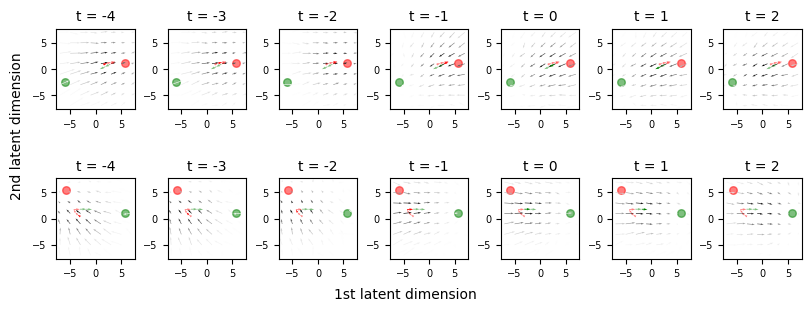

In [32]:
fig, axs = plt.subplots(nrows = len(transition_list), ncols = len(t_list), figsize = (8,3), layout = 'constrained')

for l in range(len(transition_list)):
    k1,k2 = transitions_of_interest[transition_list[l],:]
    k1 = state_order[k1]
    k2 = state_order[k2]

    mean_trajectory = np.zeros((len(t_list), 10))

    for idx in range(len(t_list)):
        ax = axs[l,idx]
        ax.tick_params(axis='y', labelsize=7)   
        ax.tick_params(axis='x', labelsize=7)

        ax.scatter(attractors[k1][0], attractors[k1][1], s = 30, c = 'red', alpha = 0.5)
        ax.scatter(attractors[k2][0], attractors[k2][1], s = 30, c = 'green', alpha = 0.5)

        t0 = t_list[idx]
        ax.set_title('t = %s'%(t0), fontsize = 10)

        x_t = []
        x_next = []
        for s in range(len(q_z)):
            zs = q_z[s]
            xs = q_x[s]
            T = len(zs)
            for t in range(1,T):
                if (zs[t-1] == k1) & (zs[t] == k2):
                    if t0<0:
                        if (t+t0) >= 0:
                            if (np.array_equal(zs[(t+t0):(t-1)], np.repeat(k1,-t0-1))):
                                x_t.append(xs[t+t0])
                                x_next.append(xs[t+t0+1])
                    else:
                        if (t+t0) <= (T-2):
                            if (np.array_equal(zs[t:(t+t0)], np.repeat(k2,t0))):
                                x_t.append(xs[t+t0])
                                x_next.append(xs[t+t0+1])
        
        x_t = np.array(x_t)
        x_next = np.array(x_next)
        dx_t = x_next - x_t

        mean_trajectory[idx,:] = np.mean(x_t, axis = 0)

        T = x_t.shape[0]
        X, Y = np.meshgrid(x, y)
        density = np.zeros(X.shape)
        U = np.zeros(X.shape)
        V = np.zeros(Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                bin_center = [X[i,j], Y[i,j]]
                xs_in_bin = []
                dx_in_bin = []
                for t in range(T):
                    if is_in_interval(x_t[t,0], bin_center[0]-bin_width, bin_center[0]+bin_width):
                        if is_in_interval(x_t[t,1], bin_center[1]-bin_width, bin_center[1]+bin_width):
                            xs_in_bin.append(x_t[t,:])
                            dx_in_bin.append(dx_t[t,:])
                if len(xs_in_bin) == 0:
                    U[i,j] = 0
                    V[i,j] = 0
                else:
                    expected_dx = np.mean(dx_in_bin, axis = 0)
                    U[i,j] = expected_dx[0]
                    V[i,j] = expected_dx[1]
                    density[i,j] = len(xs_in_bin)

        quiver = ax.quiver(X, Y, U, V, density, cmap='binary', angles='xy', scale_units='xy', scale=0.8, alpha=1)

    for idx in range(len(t_list)):
        ax = axs[l,idx]
        for t in range(len(t_list)-1):
            u = mean_trajectory[t+1,0] - mean_trajectory[t,0]
            v = mean_trajectory[t+1,1] - mean_trajectory[t,1]
            if t == idx:
                alpha = 1
            else:
                alpha = 0.5
            if t_list[t]<0:
                ax.quiver(mean_trajectory[t,0], mean_trajectory[t,1], u, v, angles='xy', scale_units='xy',scale = 1, width = 0.01, color = 'red', alpha = alpha)
            else:
                ax.quiver(mean_trajectory[t,0], mean_trajectory[t,1], u, v, angles='xy', scale_units='xy',scale = 1, width = 0.01, color = 'green', alpha = alpha)

fig.supxlabel('1st latent dimension', fontsize = 10)
fig.supylabel('2nd latent dimension', fontsize = 10, y = 0.6)

fig.get_layout_engine().set(hspace=0.2)

Fig.S8

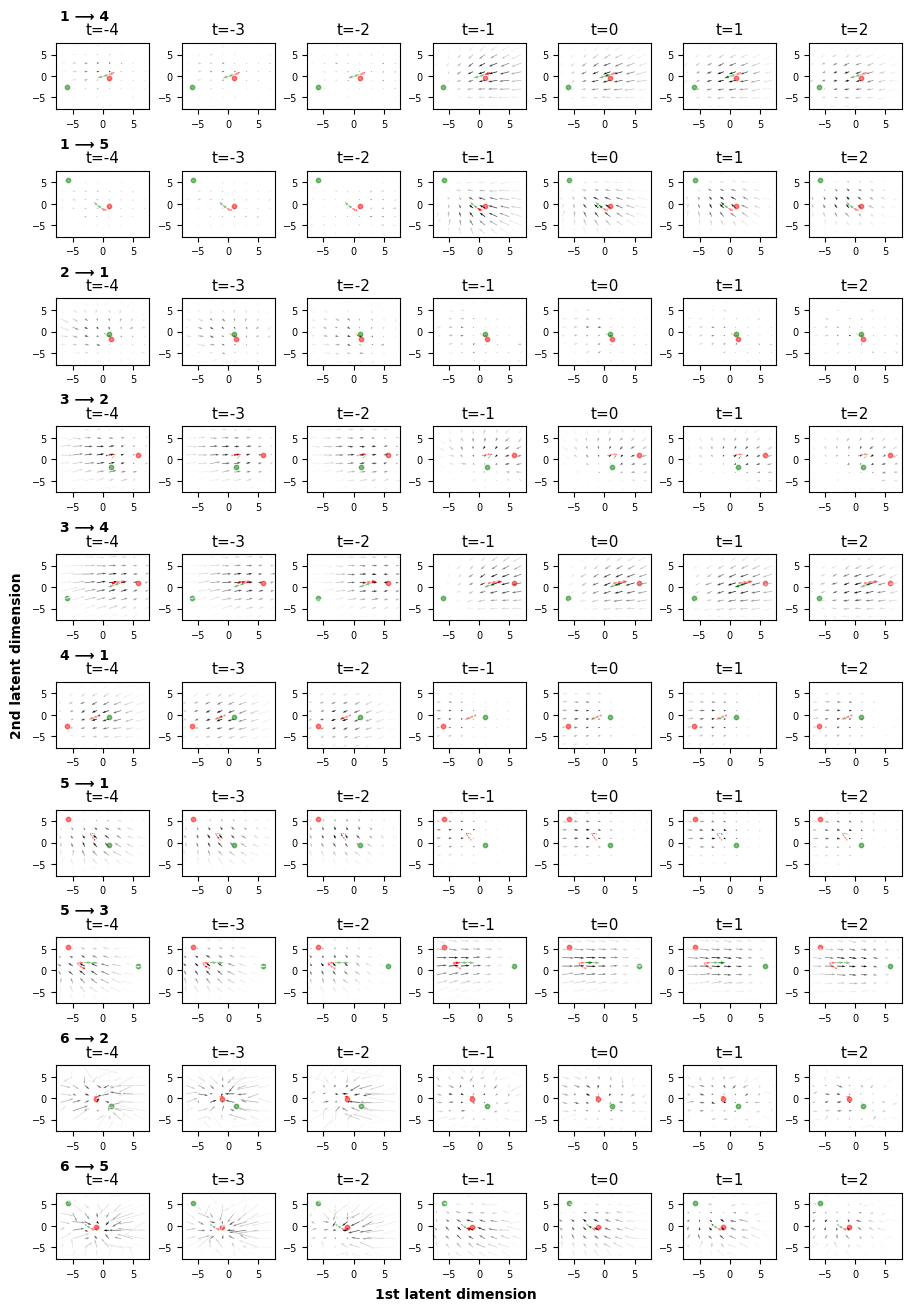

In [29]:
x_lims = (-7, 7)
y_lims = (-7, 7)

x, bin_width= np.linspace(*x_lims, 8, retstep=True)
y = np.linspace(*y_lims, 8)
bin_width = bin_width/2
X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(nrows = num_transitions, ncols = len(t_list), figsize = (9,13), layout = 'constrained')

for l in range(num_transitions):
    k1,k2 = transitions_of_interest[l,:]
    k1 = state_order[k1]
    k2 = state_order[k2]

    mean_trajectory = np.zeros((len(t_list), 10))

    for idx in range(len(t_list)):
        ax = axs[l,idx]
        ax.tick_params(axis='y', labelsize=7)   
        ax.tick_params(axis='x', labelsize=7)

        ax.scatter(attractors[k1][0], attractors[k1][1], s = 10, c = 'red', alpha = 0.5)
        ax.scatter(attractors[k2][0], attractors[k2][1], s = 10, c = 'green', alpha = 0.5)

        t0 = t_list[idx]
        ax.set_title('t=%s'%(t0), fontsize = 11)

        x_t = []
        x_next = []
        for s in range(len(q_z)):
            zs = q_z[s]
            xs = q_x[s]
            T = len(zs)
            for t in range(1,T):
                if (zs[t-1] == k1) & (zs[t] == k2):
                    if t0<0:
                        if (t+t0) >= 0:
                            if (np.array_equal(zs[(t+t0):(t-1)], np.repeat(k1,-t0-1))):
                                x_t.append(xs[t+t0])
                                x_next.append(xs[t+t0+1])
                    else:
                        if (t+t0) <= (T-2):
                            if (np.array_equal(zs[t:(t+t0)], np.repeat(k2,t0))):
                                x_t.append(xs[t+t0])
                                x_next.append(xs[t+t0+1])
        
        x_t = np.array(x_t)
        x_next = np.array(x_next)
        dx_t = x_next - x_t

        mean_trajectory[idx,:] = np.mean(x_t, axis = 0)

        T = x_t.shape[0]
        X, Y = np.meshgrid(x, y)
        density = np.zeros(X.shape)
        U = np.zeros(X.shape)
        V = np.zeros(Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                bin_center = [X[i,j], Y[i,j]]
                xs_in_bin = []
                dx_in_bin = []
                for t in range(T):
                    if is_in_interval(x_t[t,0], bin_center[0]-bin_width, bin_center[0]+bin_width):
                        if is_in_interval(x_t[t,1], bin_center[1]-bin_width, bin_center[1]+bin_width):
                            xs_in_bin.append(x_t[t,:])
                            dx_in_bin.append(dx_t[t,:])
                if len(xs_in_bin) == 0:
                    U[i,j] = 0
                    V[i,j] = 0
                else:
                    expected_dx = np.mean(dx_in_bin, axis = 0)
                    U[i,j] = expected_dx[0]
                    V[i,j] = expected_dx[1]
                    density[i,j] = len(xs_in_bin)

        quiver = ax.quiver(X, Y, U, V, density, cmap='binary', angles='xy', scale_units='xy', scale=0.8, alpha=1)

    for idx in range(len(t_list)):
        ax = axs[l,idx]
        for t in range(len(t_list)-1):
            u = mean_trajectory[t+1,0] - mean_trajectory[t,0]
            v = mean_trajectory[t+1,1] - mean_trajectory[t,1]
            if t == idx:
                alpha = 1
            else:
                alpha = 0.5
            if t_list[t]<0:
                ax.quiver(mean_trajectory[t,0], mean_trajectory[t,1], u, v, angles='xy', scale_units='xy',scale = 1, width = 0.01, color = 'red', alpha = alpha)
            else:
                ax.quiver(mean_trajectory[t,0], mean_trajectory[t,1], u, v, angles='xy', scale_units='xy',scale = 1, width = 0.01, color = 'green', alpha = alpha)

fig.supxlabel('1st latent dimension', fontsize = 10, fontweight='bold')
fig.supylabel('2nd latent dimension', fontsize = 10, y = 0.5, fontweight='bold')

row_titles = ['%s ⟶ %s'%(transitions_of_interest[i,0] + 1, transitions_of_interest[i,1] + 1) for i in range(num_transitions)]

for i, ax_row in enumerate(axs):
    middle_ax = ax_row[0]
    middle_ax.text(.3, 1.3, row_titles[i], 
                   transform=middle_ax.transAxes,
                   fontsize=10, fontweight='bold',
                   va='bottom', ha='center')

Fig.16B

In [11]:
F = dict()
for l in range(num_transitions):
    F[l] = dict()
    for t in range(len(t_list)):
        F[l][t] = np.zeros((8,8,2))

In [12]:
for l in range(num_transitions):
    k1,k2 = transitions_of_interest[l,:]
    k1 = state_order[k1]
    k2 = state_order[k2]

    for idx in range(len(t_list)):

        t0 = t_list[idx]

        x_t = []
        x_next = []
        for s in range(len(q_z)):
            zs = q_z[s]
            xs = q_x[s]
            T = len(zs)
            for t in range(1,T):
                if (zs[t-1] == k1) & (zs[t] == k2):
                    if t0<0:
                        if (t+t0) >= 0:
                            if (np.array_equal(zs[(t+t0):(t-1)], np.repeat(k1,-t0-1))):
                                x_t.append(xs[t+t0])
                                x_next.append(xs[t+t0+1])
                    else:
                        if (t+t0) <= (T-2):
                            if (np.array_equal(zs[t:(t+t0)], np.repeat(k2,t0))):
                                x_t.append(xs[t+t0])
                                x_next.append(xs[t+t0+1])
        
        x_t = np.array(x_t)
        x_next = np.array(x_next)
        dx_t = x_next - x_t

        T = x_t.shape[0]
        X, Y = np.meshgrid(x, y)
        density = np.zeros(X.shape)
        U = np.zeros(X.shape)
        V = np.zeros(Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                bin_center = [X[i,j], Y[i,j]]
                xs_in_bin = []
                dx_in_bin = []
                for t in range(T):
                    if is_in_interval(x_t[t,0], bin_center[0]-bin_width, bin_center[0]+bin_width):
                        if is_in_interval(x_t[t,1], bin_center[1]-bin_width, bin_center[1]+bin_width):
                            xs_in_bin.append(x_t[t,:])
                            dx_in_bin.append(dx_t[t,:])
                if len(xs_in_bin) == 0:
                    U[i,j] = 0
                    V[i,j] = 0
                else:
                    expected_dx = np.mean(dx_in_bin, axis = 0)
                    U[i,j] = expected_dx[0]
                    V[i,j] = expected_dx[1]    
        
        F[l][idx][:,:,0] = U
        F[l][idx][:,:,1] = V

In [13]:
dF = np.zeros((num_transitions, len(t_list)-1))
for l in range(num_transitions):
    for t in range(len(t_list)-1):
        dF[l, t] = np.nanmean([rss.cosine_similarity(F[l][t+1][i,j,:], F[l][t][i,j,:]) for i in range(8) for j in range(8)])

/home/xzhou126/ssm/resting_state_summaries.py:133: RuntimeWarning: invalid value encountered in scalar divide
  return dot_product / (norm_v1 * norm_v2)


In [14]:
transition_list = [4,7,0]

Text(0.02, 0.6, 'Cosine similarity')

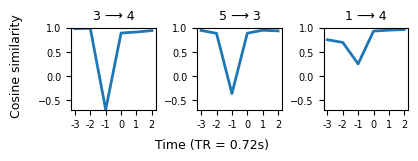

In [15]:
fig, axs = plt.subplots(nrows=1, ncols = len(transition_list), figsize = (4,1.5), layout = 'constrained')
axs = axs.flatten()
for l in range(len(transition_list)):
    ax = axs[l]
    ax.plot(dF[transition_list[l]], linewidth = 2)

    ax.tick_params(axis='y', labelsize=7)   
    ax.tick_params(axis='x', labelsize=7)
    
    ax.set_yticks([-0.5,0,0.5,1])
    ax.set_ylim([-.7,1])
    ax.set_xticks(np.arange(len(t_list))[:-1], t_list[:-1]+1)
    ax.set_title('%s ⟶ %s'%(transitions_of_interest[transition_list[l],0]+1, transitions_of_interest[transition_list[l],1]+1), fontsize = 9)

fig.supxlabel('Time (TR = 0.72s)', fontsize = 9)
fig.supylabel('Cosine similarity', fontsize = 9, y = 0.6, ha = 'center')

Fig.S9

Text(0.02, 0.6, 'Cosine similarity')

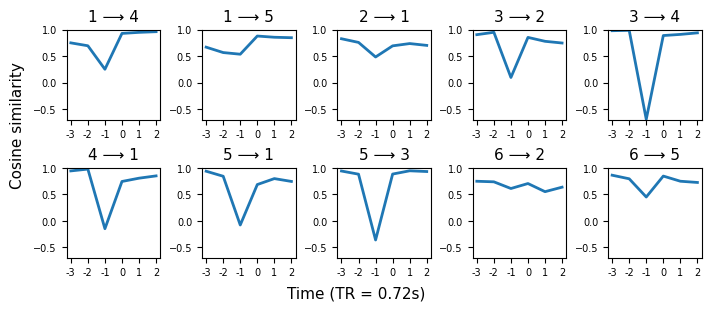

In [16]:
fig, axs = plt.subplots(nrows=2, ncols = 5, figsize = (7,3), layout = 'constrained')
axs = axs.flatten()
for l in range(num_transitions):
    ax = axs[l]
    ax.plot(dF[l], linewidth = 2)

    ax.set_yticks([-0.5,0,0.5,1])
    ax.set_ylim([-.7,1])
    ax.set_xticks(np.arange(len(t_list))[:-1], t_list[:-1]+1)
    ax.set_title('%s ⟶ %s'%(transitions_of_interest[l,0]+1, transitions_of_interest[l,1]+1), fontsize = 11)

    ax.tick_params(axis='y', labelsize=7)   
    ax.tick_params(axis='x', labelsize=7)

fig.supxlabel('Time (TR = 0.72s)', fontsize = 11)
fig.supylabel('Cosine similarity', fontsize = 11, y = 0.6)

Analysis in state space (10D)

Fig.16C

In [17]:
def collect_y_bundle(ys, z_bundle):
    y_bundle = [] 
    for i in range(len(z_bundle)):
        time_knots = np.cumsum([len(z_bundle[j]) for j in range(i)])
        if len(time_knots)==0:
            current_time = 0
        else:
            current_time = time_knots[-1]
        y_bundle.append(ys[current_time:(current_time+len(z_bundle[i])),:])
    return y_bundle

In [18]:
z_subject = dict()
x_subject = dict()
for s in range(num_subject):
    z_subject[s] = [q_z[i] for i in range(len(q_z)) if tags[i] == pid[s]]
    x_subject[s] = np.concatenate([q_x[i] for i in range(len(q_x)) if tags[i] == pid[s]])  
z_bundle_subject = dict()
x_bundle_subject = dict()
for s in range(num_subject):
    z_bundle_subject[s] = rss.collect_z_bundle(z_subject[s])
    x_bundle_subject[s] = collect_y_bundle(x_subject[s], z_bundle_subject[s])

In [19]:
C = model.parent.emissions.Cs[0]

In [20]:
sharpness = np.zeros((num_subject,num_transitions))
for s in range(num_subject):
    As = model.children[pid[s]].dynamics.As
    bs = model.children[pid[s]].dynamics.bs
    for l in range(num_transitions):
        k1,k2 = transitions_of_interest[l,:]
        k1 = state_order[k1]
        k2 = state_order[k2]
        # collect xs 
        xs_old = []
        xs_new = []
        for i in range(len(z_bundle_subject[s])-1):
            if (np.unique(z_bundle_subject[s][i]) == k1) & (np.unique(z_bundle_subject[s][i+1]) == k2):
                xs_old.append(x_bundle_subject[s][i])
                xs_new.append(x_bundle_subject[s][i+1])
        if (len(xs_old)>0) & (len(xs_new)>0):
            xs_old = np.concatenate(xs_old)
            xs_new = np.concatenate(xs_new)
            xs = np.vstack((xs_old, xs_new))
            num_sample = xs.shape[0]
            q = np.zeros(num_sample)
            for i in range(num_sample):
                F_old = As[k1] @ xs[i,:] + bs[k1] - xs[i,:]
                F_new = As[k2] @ xs[i,:] + bs[k2] - xs[i,:]
                q[i] = np.linalg.norm((F_old - F_new))       # L2 distance between vector fields
                # q[i] = np.linalg.norm(C @ (F_old - F_new))       # the same because C'C = I
            sharpness[s,l] = np.mean(q)
        else:
            sharpness[s,l] = np.nan

In [21]:
mean_sharpness = np.nanmean(sharpness, axis = 0)
sd_sharpness = np.nanstd(sharpness, axis = 0)
num_missing_subjects = np.sum(np.isnan(sharpness), axis = 0)
se = sd_sharpness/np.sqrt(num_subject-num_missing_subjects)

In [22]:
transition_list = [0,1,3,4,5,6,7]

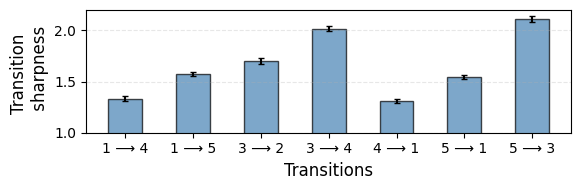

In [23]:
fig, axs = plt.subplots(figsize = (6,2))
x_labels = ['%s ⟶ %s'%(transitions_of_interest[transition_list[i],0] + 1, transitions_of_interest[transition_list[i],1] + 1) for i in range(len(transition_list))]
bars = plt.bar(x_labels, mean_sharpness[transition_list], width=0.5, color='steelblue', edgecolor='black', alpha=0.7,
               yerr = 2*se[transition_list], capsize=2)
plt.xlabel('Transitions', fontsize=12)
plt.ylabel('Transition \n sharpness', fontsize=12, ha = 'center')
plt.ylim(1,2.2)
plt.grid(axis='y', alpha=0.3, linestyle='--')  
plt.tight_layout()

Fig.S12

In [24]:
log_Q = model.parent.transitions.log_Ps 
Rs = model.parent.transitions.Rs 
def softmax(hs):
    sum_exp = np.sum(np.exp(hs))
    return np.exp(hs)/sum_exp

In [25]:
sharpness = np.zeros((num_subject,num_transitions))
for s in range(num_subject):
    As = model.children[pid[s]].dynamics.As
    bs = model.children[pid[s]].dynamics.bs

    def effective_dynamics(x, z): # compute effective one-step dynamics for state z at latent position x
        Fs = dict()
        hs = np.array([log_Q[z,k] + Rs[k,:].dot(x) for k in range(K)])
        ps = softmax(hs)
        for k in range(K):
            Fs[k] = As[k] @ x + bs[k]
        f = np.zeros(10)
        for k in range(K):
            f += ps[k]*Fs[k]
        return f

    for l in range(num_transitions):
        k1,k2 = transitions_of_interest[l,:]
        k1 = state_order[k1]
        k2 = state_order[k2]
        # collect xs 
        xs = []
        for i in range(len(z_bundle_subject[s])-1):
            if (np.unique(z_bundle_subject[s][i]) == k1) & (np.unique(z_bundle_subject[s][i+1]) == k2):
                old_state_length = len(z_bundle_subject[s][i])
                new_state_length = len(z_bundle_subject[s][i+1])
                if (old_state_length>=2) & (new_state_length>=2):
                    xs.append(x_bundle_subject[s][i][(old_state_length-2):old_state_length,:])
                    xs.append(x_bundle_subject[s][i+1][0:2,:])
        if len(xs)>0:
            xs = np.concatenate(xs)
            num_sample = xs.shape[0]
            q = np.zeros(num_sample)
            for i in range(num_sample):
                F_old = effective_dynamics(xs[i,:], k1) - xs[i,:]
                F_new = effective_dynamics(xs[i,:], k2) - xs[i,:]
                q[i] = np.linalg.norm(F_old - F_new)      
            sharpness[s,l] = np.mean(q)
        else:
            sharpness[s,l] = np.nan

In [26]:
mean_sharpness = np.nanmean(sharpness, axis = 0)
sd_sharpness = np.nanstd(sharpness, axis = 0)
num_missing_subjects = np.sum(np.isnan(sharpness), axis = 0)
se = sd_sharpness/np.sqrt(num_subject-num_missing_subjects)

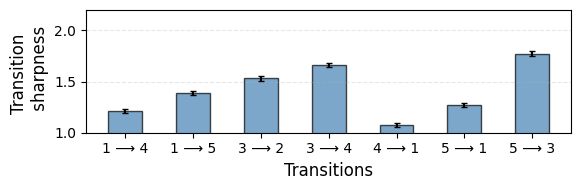

In [27]:
fig, axs = plt.subplots(figsize = (6,2))
x_labels = ['%s ⟶ %s'%(transitions_of_interest[transition_list[i],0] + 1, transitions_of_interest[transition_list[i],1] + 1) for i in range(len(transition_list))]
bars = plt.bar(x_labels, mean_sharpness[transition_list], width=0.5, color='steelblue', edgecolor='black', alpha=0.7,
               yerr = 2*se[transition_list], capsize=2)
plt.xlabel('Transitions', fontsize=12)
plt.ylabel('Transition \n sharpness', fontsize=12, ha = 'center')
plt.ylim(1,2.2)
plt.grid(axis='y', alpha=0.3, linestyle='--')  
plt.tight_layout()